In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.decomposition import TruncatedSVD


In [3]:
import os
import sys
import math
import pyspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

In [5]:
import os
os.environ['SPARK_LOCAL_IP']='127.0.0.1'

In [7]:
os.environ['SPARK_HOME'] = "/opt/homebrew/Cellar/apache-spark/3.5.3/libexec"
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
#os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"PySpark version: {pyspark.__version__}")

System version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
Pandas version: 2.2.3
PySpark version: 3.5.3


In [241]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import ALS as ALS_m
from pyspark.ml.evaluation import RegressionEvaluator 
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType



In [12]:
#!/opt/homebrew/Cellar/apache-spark/3.5.3/libexec/bin/spark-shell --driver-memory 5g

In [15]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
conf = SparkConf()

In [17]:
#conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '20g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g'), ("spark.sql.shuffle.partitions", "16"),("spark.driver.maxResultSize","4g"),("spark.sql.execution.arrow.enabled", "true")])

In [19]:
conf.setExecutorEnv(pairs =[('spark.executor.memory', '20g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g'), ("spark.sql.shuffle.partitions", "16"),("spark.driver.maxResultSize","4g"),("spark.sql.execution.arrow.enabled", "true")])

In [21]:
print(conf.toDebugString())

spark.executorEnv.spark.executor.memory=20g
spark.executorEnv.spark.app.name=Spark Updated Conf
spark.executorEnv.spark.executor.cores=4
spark.executorEnv.spark.cores.max=4
spark.executorEnv.spark.driver.memory=4g
spark.executorEnv.spark.sql.shuffle.partitions=16
spark.executorEnv.spark.driver.maxResultSize=4g
spark.executorEnv.spark.sql.execution.arrow.enabled=true


In [23]:
# from pyspark import SparkContext
# SparkContext.setSystemProperty('spark.executor.memory', '10g')

In [25]:
#spark.sparkContext.stop()

In [27]:
#spark = SparkSession.builder.appName('Recommender').getOrCreate() 
#spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark = SparkSession.builder.appName('Recommender ALS').config(conf=conf).getOrCreate() 
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")
spark.sparkContext.setLogLevel("ERROR")
#spark.conf.set("spark.executor.memory", "10g")
#spark.conf.set("spark.executor.cores", "2")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 13:24:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
input_data=spark.read.csv('df_final.csv',inferSchema=True,header=True)
input_data.show(3)

+------------------+-----+------------+-------------------+-------------+------------------+----------------+-----------------+-----------------+----------------+--------------------+--------------------+------------+--------------------+-------------+--------------+--------------------+--------------------+--------------------+-------------------+-----------+------------+-------------------+-------------------+-----------------------------+
|       total_value|price|review_score|order_item_quantity|freight_value|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|            order_id|         customer_id|order_status|  customer_unique_id|customer_city|customer_state|           review_id|          product_id|           seller_id|   product_category|seller_city|seller_state| order_purchased_at|  order_approved_at|order_estimated_delivery_date|
+------------------+-----+------------+-------------------+-------------+------------------+----------------

In [32]:
input_data=spark.read.option('header', True).csv('df_final.csv')

In [34]:
input_data.filter(input_data['customer_unique_id'].isNotNull()).count()

113475

In [35]:
input_data.printSchema()

root
 |-- total_value: string (nullable = true)
 |-- price: string (nullable = true)
 |-- review_score: string (nullable = true)
 |-- order_item_quantity: string (nullable = true)
 |-- freight_value: string (nullable = true)
 |-- product_photos_qty: string (nullable = true)
 |-- product_weight_g: string (nullable = true)
 |-- product_length_cm: string (nullable = true)
 |-- product_height_cm: string (nullable = true)
 |-- product_width_cm: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- seller_city: string (nullable = true)
 |-- seller_state: string (nullable = true)
 |--

In [38]:
input_data.groupby('product_id').agg(f.collect_set('product_category'))\
                        .filter(size(col('collect_set(product_category)')) == 1).count()

32265

In [39]:
input_data.select(f.countDistinct("product_category")).show()

+--------------------------------+
|count(DISTINCT product_category)|
+--------------------------------+
|                              73|
+--------------------------------+



In [40]:
input_data.select(f.countDistinct("customer_unique_id")).show()

+----------------------------------+
|count(DISTINCT customer_unique_id)|
+----------------------------------+
|                             92268|
+----------------------------------+



In [43]:
input_data.select(f.countDistinct("order_id")).show()

+------------------------+
|count(DISTINCT order_id)|
+------------------------+
|                   95295|
+------------------------+



In [45]:
input_data.select(f.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     32265|
+--------------------------+



## Data Preprocessing 

## Feature Engineering

In [49]:
def preprocess(df):
    
    # Change data types
    df = df.withColumn('order_purchased_at', to_timestamp('order_purchased_at'))
    df = df.withColumn('customer_unique_id', col('customer_unique_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('order_id', col('order_id').cast('integer'))
    return df

In [52]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(
                                      first('product_category').alias('product_category'),
                                      countDistinct('order_id').alias('number_of_orders'),
                                      mean('price').alias('price'),
                                      min('order_purchased_at').alias('first_date'),
                                      max('order_purchased_at').alias('last_date'))
    
    return df

In [54]:
def category_features(df):
    
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('product_category').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('product_category').agg(countDistinct('product_id').alias('number_of_products'),
                                       countDistinct('order_id').alias('number_of_orders'))
                                       
  
    df = df.join(products, on='product_category')
    
    return df

In [56]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('customer_unique_id').agg(
                                   countDistinct('product_id').alias('distinct_products_purchased'),
                                    countDistinct('order_id').alias('number_of_orders'),
                                   
                                   mean('price').alias('average_price_purchased'),
                                   mean('relative_price').alias('avg_relative_price_purchased'),
                                   min('order_purchased_at').alias('first_date'),
                                   max('order_purchased_at').alias('last_date'))
    

    return df

In [58]:
def calculate_relative_price(products):
    
    categories = products.groupby('product_category').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))
    
    # Calculate relative price
    products = products.join(categories, on='product_category')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))
    
    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [60]:
df_freq = input_data.groupBy('customer_unique_id').agg(countDistinct('order_id').alias('frequency'))

In [62]:
df_freq.show()

+--------------------+---------+
|  customer_unique_id|frequency|
+--------------------+---------+
|8033f408bcb751340...|        1|
|384ffc528dd30fd49...|        1|
|14a188558af6cd5bc...|        2|
|70154c8e9a3800762...|        1|
|508723a71df892b74...|        1|
|968436577c1e2073b...|        1|
|c2495d0891221237c...|        1|
|e533c359f12f90838...|        1|
|0e1a29e5ec2a8b40b...|        1|
|71430416a809573ed...|        1|
|958da6ff0122fa69b...|        1|
|d84d21b7b4970bdb5...|        1|
|b138f736fd2e7162c...|        1|
|4011b7579e894fa92...|        2|
|505953fd10284b83b...|        1|
|63590d97e0d4877dc...|        1|
|4a055e75b893bfa3d...|        1|
|c8d8b3853ff0a31da...|        1|
|a6408b4025cdea6e8...|        1|
|10a019fa89b5f15af...|        1|
+--------------------+---------+
only showing top 20 rows



In [63]:
#df=preprocess(input_data)

In [64]:
input_data = input_data.withColumn('order_purchased_at', to_timestamp('order_purchased_at'))

In [65]:
products=product_features(input_data)
categories=category_features(input_data)

In [66]:
products.show()

+--------------------+--------------------+----------------+------------------+-------------------+-------------------+
|          product_id|    product_category|number_of_orders|             price|         first_date|          last_date|
+--------------------+--------------------+----------------+------------------+-------------------+-------------------+
|00066f42aeeb9f300...|           perfumery|               1|             105.9|2018-05-20 18:45:21|2018-05-20 18:45:21|
|0011c512eb256aa0d...|          automobile|               1|             18.99|2017-12-14 20:30:29|2017-12-14 20:30:29|
|00126f27c81360368...|          cool_stuff|               2|              77.0|2017-09-17 20:35:28|2017-09-17 20:45:13|
|001795ec6f1b187d3...|      consoles_games|               7|134.58666666666667|2017-10-28 18:16:38|2017-12-27 00:22:18|
|001b237c0e9bb435f...|      bed_bath_table|               1|             367.9|2018-08-09 01:24:57|2018-08-09 01:24:57|
|001c5d71ac6ad696d...|      bed_bath_tab

In [71]:
categories.show()

+--------------------+------------------+----------------+------------------+
|    product_category|number_of_products|number_of_orders|     average_price|
+--------------------+------------------+----------------+------------------+
|fashion_bag_acces...|               837|            1812|102.71479091995245|
|                 art|                54|             197| 98.18000000000002|
|           beverages|                79|             290| 80.68000000000002|
|             flowers|                14|              28| 91.12714285714286|
|   home_construction|               221|             472|101.56040723981891|
|            pc_gamer|                 3|               8| 43.23333333333333|
|fashion_male_clot...|                91|             109| 98.46153846153847|
|kitchen_dining_la...|                91|             238|122.22582417582413|
|          la_cuisine|                 8|              10|         116.40875|
|      bed_bath_table|              2948|            9060|111.36

In [72]:
relative_prices = calculate_relative_price(products)
relative_prices.show()
df = input_data.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')
products.show()

+--------------------+--------------------+
|          product_id|      relative_price|
+--------------------+--------------------+
|fff9553ac224cec9d...| -0.7105955617928253|
|ffd4bf4306745865e...|-0.28222670525977245|
|ff9032482857269e8...|-0.09652662047188834|
|ff8bd09f659b88af0...|-0.06591527059029917|
|fde4e97b75bd817d8...|  1.2491667397596702|
|fdd4f5e099d232bbd...| -0.5000877116042453|
|fc5feda8d6c915bdb...| -0.7895360056135428|
|fc4d6bb8b2fba6297...| -0.5933690027190598|
|fc4179aaee80873ac...| -0.3302341899833348|
|fb614bd62b359254b...| -0.3960178931672661|
|fa812218786a729a8...|-0.01690641171827...|
|f9a4667b264a6823e...|-0.01315674063678...|
|f727305c90ca9b9c3...|-1.31567406367929...|
|f610782a58cacbcdd...|  0.6248793965441629|
|f60836d2827709716...|-0.13204982019121125|
|f4c9a2926d5a2fe09...|  0.5504451363915447|
|f4a9b2ee7355882bd...| -0.2960266643276906|
|f2ee381460f893efb...|  0.9209718445750373|
|f1f2a5b4dd03a85b6...| 0.18406280150863955|
|f1cf1f7cd5a15a080...|-0.0672309

+--------------------+--------------------+----------------+-----------------+-------------------+-------------------+--------------------+
|          product_id|    product_category|number_of_orders|            price|         first_date|          last_date|      relative_price|
+--------------------+--------------------+----------------+-----------------+-------------------+-------------------+--------------------+
|fff9553ac224cec9d...|fashion_bag_acces...|               1|            25.99|2017-10-06 16:44:05|2017-10-06 16:44:05| -0.7105955617928253|
|ffd4bf4306745865e...|fashion_bag_acces...|               8| 58.5488888888889|2017-04-26 12:11:30|2018-08-18 21:12:42|-0.28222670525977245|
|ff9032482857269e8...|fashion_bag_acces...|               3|72.66333333333334|2017-09-03 14:50:19|2018-01-07 21:07:17|-0.09652662047188834|
|ff8bd09f659b88af0...|fashion_bag_acces...|               1|            74.99|2017-09-15 22:01:18|2017-09-15 22:01:18|-0.06591527059029917|
|fde4e97b75bd817d8..

In [73]:

products.sort('number_of_orders', ascending=False).toPandas().head(20)

,product_id,product_category,number_of_orders,price,first_date,last_date,relative_price
0,99a4788cb24856965c36a24e339b6058,bed_bath_table,448,114.423036,2017-02-28 11:11:32,2018-08-19 18:03:14,0.357126
1,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,422,107.484122,2017-07-25 10:50:22,2018-08-18 16:37:58,0.286849
2,422879e10f46682990de24d770e7f83d,garden_tools,341,110.584440,2017-05-02 18:34:59,2018-08-14 09:18:25,0.214379
3,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,310,113.852639,2017-02-15 16:31:44,2018-08-22 18:27:48,0.340047
4,389d119b48cf3043d311335e499d9c6b,garden_tools,305,111.544875,2017-05-02 18:34:59,2018-08-16 23:08:45,0.225056
5,53b36df67ebb7c41585e8d54d6772e08,watches_gifts,292,113.673642,2017-06-11 13:04:43,2018-08-01 19:01:08,0.375722
6,53759a2ecddad2bb87a079a1f1519f73,garden_tools,282,107.533377,2017-04-07 13:27:27,2018-08-22 16:31:45,0.180461
7,368c6c730842d78016ad823897a372db,garden_tools,277,113.841474,2017-07-18 10:22:32,2018-08-25 20:10:27,0.250586
8,154e7e31ebfa092203795c972e5804a6,health_beauty,265,92.853034,2017-02-03 22:32:04,2018-08-13 13:08:25,0.109342
9,2b4609f8948be18874494203496bc318,health_beauty,253,107.182210,2017-03-09 23:55:22,2018-08-27 16:12:22,0.300653


In [74]:
users = user_features(df)
users.show()

+--------------------+---------------------------+----------------+-----------------------+----------------------------+-------------------+-------------------+
|  customer_unique_id|distinct_products_purchased|number_of_orders|average_price_purchased|avg_relative_price_purchased|         first_date|          last_date|
+--------------------+---------------------------+----------------+-----------------------+----------------------------+-------------------+-------------------+
|5f439c10be261b762...|                          1|               1|                  45.99|         0.24232227784730936|2017-12-04 12:21:45|2017-12-04 12:21:45|
|b6d4032296c0a345f...|                          1|               1|                   45.9|         -0.5616053694952402|2018-02-06 21:37:26|2018-02-06 21:37:26|
|2d006f3f447dba013...|                          1|               1|                  151.9|          0.8102225784573648|2018-01-28 18:28:32|2018-01-28 18:28:32|
|b68acf578f10bd6ec...|            

## Train Recommendation Model

In [180]:
input_df=pd.read_csv('df_final.csv')

In [182]:
input_df.columns

Index(['total_value', 'price', 'review_score', 'order_item_quantity',
       'freight_value', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_id', 'customer_id', 'order_status', 'customer_unique_id',
       'customer_city', 'customer_state', 'review_id', 'product_id',
       'seller_id', 'product_category', 'seller_city', 'seller_state',
       'order_purchased_at', 'order_approved_at',
       'order_estimated_delivery_date'],
      dtype='object')

In [184]:
# from sklearn.preprocessing import LabelEncoder

# u_transf = LabelEncoder()
# item_transf = LabelEncoder()
# # encoding
# input_data['customer_unique_id'] = u_transf.fit_transform(input_data['customer_unique_id'])
# input_data['product_id'] = item_transf.fit_transform(input_data['product_id'])

In [186]:
def reduce_sparsity(df, min_items_per_user, min_user_per_item, user_col='customer_unique_id', item_col='product_id'):
    good_users = df[user_col].value_counts()[df[user_col].value_counts() > min_items_per_user].index
    df = df[df[user_col].isin(good_users)]

    good_items = df[item_col].value_counts()[df[item_col].value_counts() > min_user_per_item].index
    df = df[df[item_col].isin(good_items)].reset_index(drop=1)

    return df

In [188]:
#%%
df_final=reduce_sparsity(input_df, 1, 10)
df_final.shape

(8884, 25)

In [190]:

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['customer_unique_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['product_id'].nunique())

The number of observations in the final data = 8884
Number of unique USERS in the final data =  3805
Number of unique PRODUCTS in the final data =  364


In [192]:
final_ratings_matrix = df_final.groupby(['customer_unique_id', 'product_id'])['review_score'].mean().unstack(fill_value=0)


print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

# Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

# Density of ratings
density = (given_num_of_ratings / possible_num_of_ratings)
density *= 100
print('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (3805, 364)
given_num_of_ratings =  4254
possible_num_of_ratings =  1385020
density: 0.31%


product_id,00ba6d766f0b1d7b78a5ce3e1e033263,0152f69b6cf919bcdaf117aa8c43e5a2,017692475c1c954ff597feda05131d73,03e1c946c0ddfc58724ff262aef08dff,0449db5eede617c5fd413071d582f038,04c4a4b9c924494fcf82e0fba966f955,054515fd15bc1a2029f10de97ffa9120,0554911df28fda9fd668ce5ba5949695,060c17562f97e5bb60bc0dfa4dd5b3f2,060cb19345d90064d1015407193c233d,...,f819f0c84a64f02d3a5606ca95edd272,f8ea5fcf9c628485e01b9c3cf52728c2,f919da4f716dc149cef4551a322001fd,fa126ff62aae83e37857ad495641c878,fb55982be901439613a95940feefd9ee,fb783e3e545937820b57fe539b2c5a6c,fbc1488c1a1e72ba175f53ab29a248e8,fbce4c4cb307679d89a3bf3d3bb353b9,fc1d8637c0268af3db482c14b7ef8e75,fe6a9515d655fa7936b8a7c841039f34
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
001147e649a7b1afd577e873841632dd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001926cef41060fae572e2e7b30bd2a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002ae492472e45ad6ebeb7a625409392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003e2af81ea3c72fbdd093f07724a4de,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004177f7bf62929186b32c7fdaa6157b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
user_ratings=final_ratings_matrix.stack().reset_index(name='rating')

In [196]:
user_ratings

,customer_unique_id,product_id,rating
0,001147e649a7b1afd577e873841632dd,00ba6d766f0b1d7b78a5ce3e1e033263,0.0
1,001147e649a7b1afd577e873841632dd,0152f69b6cf919bcdaf117aa8c43e5a2,0.0
2,001147e649a7b1afd577e873841632dd,017692475c1c954ff597feda05131d73,0.0
3,001147e649a7b1afd577e873841632dd,03e1c946c0ddfc58724ff262aef08dff,0.0
4,001147e649a7b1afd577e873841632dd,0449db5eede617c5fd413071d582f038,0.0
...,...,...,...
1385015,ffad6a7a0e13be3dfd9de96a81b77c9e,fb783e3e545937820b57fe539b2c5a6c,0.0
1385016,ffad6a7a0e13be3dfd9de96a81b77c9e,fbc1488c1a1e72ba175f53ab29a248e8,0.0
1385017,ffad6a7a0e13be3dfd9de96a81b77c9e,fbce4c4cb307679d89a3bf3d3bb353b9,0.0
1385018,ffad6a7a0e13be3dfd9de96a81b77c9e,fc1d8637c0268af3db482c14b7ef8e75,0.0


In [198]:
df_data=spark.createDataFrame(user_ratings)

In [199]:
df_data.show(5)

+--------------------+--------------------+------+
|  customer_unique_id|          product_id|rating|
+--------------------+--------------------+------+
|001147e649a7b1afd...|00ba6d766f0b1d7b7...|   0.0|
|001147e649a7b1afd...|0152f69b6cf919bcd...|   0.0|
|001147e649a7b1afd...|017692475c1c954ff...|   0.0|
|001147e649a7b1afd...|03e1c946c0ddfc587...|   0.0|
|001147e649a7b1afd...|0449db5eede617c5f...|   0.0|
+--------------------+--------------------+------+
only showing top 5 rows



In [202]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(df_data.columns)-set(['rating'])) ]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_data).transform(df_data)
transformed.show()

+--------------------+--------------------+------+------------------------+----------------+
|  customer_unique_id|          product_id|rating|customer_unique_id_index|product_id_index|
+--------------------+--------------------+------+------------------------+----------------+
|001147e649a7b1afd...|00ba6d766f0b1d7b7...|   0.0|                     0.0|             0.0|
|001147e649a7b1afd...|0152f69b6cf919bcd...|   0.0|                     0.0|             1.0|
|001147e649a7b1afd...|017692475c1c954ff...|   0.0|                     0.0|             2.0|
|001147e649a7b1afd...|03e1c946c0ddfc587...|   0.0|                     0.0|             3.0|
|001147e649a7b1afd...|0449db5eede617c5f...|   0.0|                     0.0|             4.0|
|001147e649a7b1afd...|04c4a4b9c924494fc...|   0.0|                     0.0|             5.0|
|001147e649a7b1afd...|054515fd15bc1a202...|   0.0|                     0.0|             6.0|
|001147e649a7b1afd...|0554911df28fda9fd...|   0.0|                    

In [204]:
transformed.groupBy("customer_unique_id").count().orderBy("count", ascending=False).show(10)
transformed.groupBy("product_id").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|  customer_unique_id|count|
+--------------------+-----+
|14a188558af6cd5bc...|  364|
|1d2435aa3b858d45c...|  364|
|0cf0c4ba8023930f2...|  364|
|20a5257c01689ac69...|  364|
|068b769463d8f4148...|  364|
|0fb360a422d2297dc...|  364|
|200d8b1f16d0cc960...|  364|
|208fe9aa6033a7741...|  364|
|20ae758fb6688386d...|  364|
|078401292a38d006a...|  364|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|          product_id|count|
+--------------------+-----+
|35bc6c77029697004...| 3805|
|a3daee3915d4fb983...| 3805|
|64fb265487de22386...| 3805|
|53b36df67ebb7c415...| 3805|
|d5991653e037ccb7a...| 3805|
|36f60d45225e60c7d...| 3805|
|d3c044bd42d84a79e...| 3805|
|130482add9fd75ccb...| 3805|
|473795a355d29305c...| 3805|
|70906e04da1eebf3d...| 3805|
+--------------------+-----+
only showing top 10 rows



In [206]:
(training,test)=transformed.randomSplit([0.8, 0.2])

In [208]:
training = training.repartition(200, "customer_unique_id")

In [210]:
# dfs_train, dfs_test = spark_random_split(df_data, ratio=0.75, seed=42)

In [212]:
# als = ALS(
#     maxIter=MAX_ITER, 
#     rank=RANK,
#     regParam=REG_PARAM, 
#     userCol=COL_USER, 
#     itemCol=COL_ITEM, 
#     ratingCol=COL_RATING, 
#     coldStartStrategy="drop"
# )

# model = als.fit(dfs_train)

### Cross Validation for Model Hyperparameters Tuning

In [263]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):
    
    # Define the ALS model
    als = ALS(userCol="customer_unique_id_index",itemCol="product_id_index",ratingCol="rating", 
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=False)

    # Define the parameter grid for hyperparameter tuning
    param_grid = ParamGridBuilder().addGrid(als.rank, [1, 20, 30])\
    .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
    .addGrid(als.maxIter, [10, 20])\
    .build()
        
    # Define the evaluator for computing the evaluation metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

    # Define the cross-validator for performing 5-fold cross-validation
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

    # Define the pipeline for fitting the model and evaluating it
    pipeline = Pipeline(stages=[cv])

    # Fit the pipeline on the data and evaluate the model
    model = pipeline.fit(interaction_matrix)
    
    return model


In [265]:
model = cross_validate_als(training)

# Model with the lowest RMSE value 
#bestModel = model.stages[0].bestModel


In [267]:
best_model = model.stages[0].bestModel
print('rank: ', best_model.rank)
print('MaxIter: ', best_model._java_obj.parent().getMaxIter())
print('RegParam: ', best_model._java_obj.parent().getRegParam())
print('alpha: ',  bestModel._java_obj.parent().getAlpha())

rank:  30
MaxIter:  10
RegParam:  0.05
alpha:  0.0


In [269]:

# Make predictions
predictions = bestModel.transform(training)
predictions.show()


+--------------------+--------------------+------+------------------------+----------------+-------------+
|  customer_unique_id|          product_id|rating|customer_unique_id_index|product_id_index|   prediction|
+--------------------+--------------------+------+------------------------+----------------+-------------+
|6e62ba22142e89bac...|0152f69b6cf919bcd...|   0.0|                  1591.0|             1.0|1.1131893E-15|
|6e62ba22142e89bac...|017692475c1c954ff...|   0.0|                  1591.0|             2.0|          0.0|
|6e62ba22142e89bac...|03e1c946c0ddfc587...|   0.0|                  1591.0|             3.0|          0.0|
|6e62ba22142e89bac...|0449db5eede617c5f...|   0.0|                  1591.0|             4.0|          0.0|
|6e62ba22142e89bac...|04c4a4b9c924494fc...|   0.0|                  1591.0|             5.0|          0.0|
|6e62ba22142e89bac...|054515fd15bc1a202...|   0.0|                  1591.0|             6.0|          0.0|
|6e62ba22142e89bac...|060c17562f97e5b

In [271]:
# Calculate RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))


 rmse:0.2252487336756801 mae:0.012192261015594922


In [321]:
training_df=training.select(col("customer_unique_id_index"),col("product_id_index"), col("rating"))
train, validation=training_df.randomSplit([0.7,0.3], seed=99)

In [323]:
def train_and_evaluate_als(training, validation, rank, regParam, maxIter):
    als = ALS(maxIter=maxIter, rank=rank, regParam=regParam, userCol="customer_unique_id_index",itemCol="product_id_index",ratingCol="rating", 
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=False)
    model = als.fit(training)

    predictions = model.transform(validation)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    return rmse

In [325]:
iterations = [2, 5, 10, 15, 20]
rmse_values = []
for iter in iterations:
    rmse = train_and_evaluate_als(training, validation, rank=30, regParam=0.05, maxIter=iter)
    rmse_values.append(rmse)

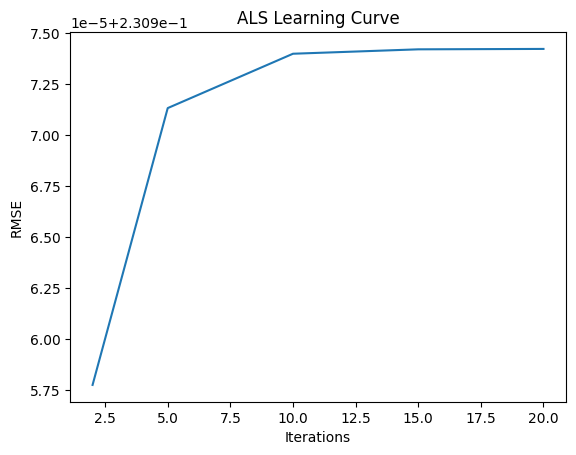

In [327]:
plt.plot(iterations, rmse_values)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("ALS Learning Curve")
plt.show()

The graph shows that RMSE is increasing with number of iterations, and the model is overfitting.

### Training Model

In [273]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

#def simple_als(interaction_matrix):
    
    # Train-test split
    #(train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
als = ALS(userCol="customer_unique_id_index",itemCol="product_id_index",ratingCol="rating", maxIter=10,
          alpha=0.0, regParam=0.05, rank=30, implicitPrefs=True, 
          nonnegative=True, coldStartStrategy='drop')

# Fit the ALS model on the ratings data
model = als.fit(training)

# Make predictions
predictions = best_model.transform(test)

# Calculate the RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print('test rmse:' + str(rmse) + ' mae:' + str(mae))




test rmse:0.23140925140413796 mae:0.012268902783183091


In [227]:
userRecs = model.recommendForAllUsers(100) 
userRecs.show(10)

+------------------------+--------------------+
|customer_unique_id_index|     recommendations|
+------------------------+--------------------+
|                      26|[{99, 1.22042E-4}...|
|                      27|[{99, 5.904459E-9...|
|                      28|[{99, 4.9281876E-...|
|                      31|[{99, 1.2435938E-...|
|                      34|[{214, 1.7780683E...|
|                      44|[{84, 2.318453E-9...|
|                      53|[{122, 0.90258265...|
|                      65|[{363, 0.0}, {362...|
|                      76|[{36, 0.001375694...|
|                      78|[{36, 5.123226E-1...|
+------------------------+--------------------+
only showing top 10 rows



In [275]:
# 3 random users
user_subset = [85, 170, 200]

# Recommend top 500 products for the users
recommendations = spark.createDataFrame([(user, 0) for user in user_subset], ['customer_unique_id_index', 'product_id_index'])
recommendations = model.recommendForUserSubset(recommendations, 5)

In [277]:
recommendations.show()

+------------------------+--------------------+
|customer_unique_id_index|     recommendations|
+------------------------+--------------------+
|                      85|[{296, 0.24676909...|
|                     200|[{117, 4.0225426E...|
|                     170|[{97, 0.9527734},...|
+------------------------+--------------------+



In [279]:

recs_for_user_1 = spark.createDataFrame(recommendations.collect()[1][1])
recs_for_user_1.show()

+----------------+--------------------+
|product_id_index|              rating|
+----------------+--------------------+
|             117|4.022542634629644...|
|             347|3.083144838456064...|
|             243|1.883283584902528...|
|              24|3.774537162826163...|
|             232|1.071112365025328...|
+----------------+--------------------+



In [ ]:
# def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
   
#     recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
    
#     user_avg_relative_price = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()[0][1]

    
#     # Scale CF rating score, ranges from 0 to 2
#     recs = recs.withColumn('rating', col('rating') / 2)
    
#     # Scale purchase_per_view rate, ranges from 0 to 0.075
#     recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
#     # Scale relative price value, ranges from -5 to 5
#     recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
#     # Scale users average relative price value, ranges from -1 to 1
#     user_avg_relative_price = (user_avg_relative_price + 1) / 2
    
    
#     # Calculate the recommendation scores
#     recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit)) 

    
#     # Scale back CF rating score, ranges from 0 to 2
#     recs = recs.withColumn('rating', col('rating') * 2)

#     # Scale back purchase_per_view rate, ranges from 0 to 0.075
#     recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
#     # Scale back relative price value, ranges from -1 to 1
#     recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

#     # Scale back average relative price value, ranges from -5 to 5
#     user_avg_relative_price = user_avg_relative_price * 10 - 5
    
#     return recs

### Evaluation

In [285]:
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql.functions import col, collect_list

# Prepare the input for RankingMetrics
user_ground_truth = test.groupby('customer_unique_id_index').agg(collect_list('product_id_index').alias('ground_truth_items'))
user_train_items = training.groupby('customer_unique_id_index').agg(collect_list('product_id_index').alias('train_items'))

# Join the recommendations and ground truth data on the user ID
user_eval = userRecs.join(user_ground_truth, on='customer_unique_id_index').join(user_train_items, on='customer_unique_id_index') \
    .select('customer_unique_id_index', 'recommendations.product_id_index', 'ground_truth_items', 'train_items', 'recommendations.rating')
user_eval = user_eval.toPandas()
user_eval['itemIndex_filtered'] = user_eval.apply(lambda x:[b for (b,z) in zip(x.product_id_index, x.rating) if b not in x.train_items], axis=1)
user_eval['rating_filtered'] = user_eval.apply(lambda x:[z for (b,z) in zip(x.product_id_index, x.rating) if b not in x.train_items], axis=1)

In [293]:
user_eval.head()

,customer_unique_id_index,product_id_index,ground_truth_items,train_items,rating,itemIndex_filtered,rating_filtered,precision
0,496,"[363, 362, 361, 360, 359, 358, 357, 356, 355, ...","[3.0, 13.0, 21.0, 33.0, 36.0, 46.0, 48.0, 52.0...","[0.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[361, 359, 358, 353, 339, 329, 315, 306, 299, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.542117
1,596,"[363, 362, 361, 360, 359, 358, 357, 356, 355, ...","[1.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 25.0, 3...","[0.0, 2.0, 3.0, 6.0, 8.0, 9.0, 11.0, 12.0, 13....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[362, 350, 344, 327, 326, 325, 318, 311, 307, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.536759
2,1051,"[99, 80, 11, 24, 59, 289, 243, 296, 272, 22, 1...","[2.0, 6.0, 13.0, 16.0, 20.0, 29.0, 31.0, 35.0,...","[0.0, 1.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0,...","[6.310345024296282e-10, 3.5043034012777197e-12...","[243, 225, 155, 70, 45, 246, 171, 309, 173, 19...","[1.2526346062843863e-12, 1.6880703920200274e-1...",0.618995
3,1350,"[84, 24, 243, 90, 122, 97, 285, 211, 36, 99, 6...","[4.0, 14.0, 15.0, 20.0, 26.0, 29.0, 41.0, 52.0...","[0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.8584790825843811, 0.0488542802631855, 0.034...","[122, 97, 211, 68, 232, 238, 250, 179, 59, 272...","[0.023703014478087425, 0.019505321979522705, 0...",0.730919
4,2821,"[363, 362, 361, 360, 359, 358, 357, 356, 355, ...","[1.0, 11.0, 17.0, 21.0, 27.0, 28.0, 33.0, 40.0...","[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[356, 354, 352, 339, 336, 327, 317, 316, 305, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.542117


In [ ]:
ranking_metrics = RankingMetrics(user_preds.rdd.map(lambda x: (x[1].item_id, x[1].rating)))
ndcg_at_k = ranking_metrics.ndcgAt(k=10) 

In [319]:

def compute_dcg(v):
    """
    Compute DCG for a given list of relevance scores.
    
    Parameters:
    v (list): List of relevance scores.
    
    Returns:
    float: Discounted Cumulative Gain (DCG).
    """
    if not v:
        return 0.0
    return sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(v)])

# Register the function as a PySpark UDF
dcg_udf = udf(compute_dcg, FloatType())

In [311]:
import numpy as np
import math
def score(predicted, actual, metric):
        """
        Parameters
        ----------
        predicted : List
            List of predicted apps.
        actual : List
            List of masked apps.
        metric : 'precision' or 'ndcg'
            A valid metric for recommendation.
        Raises
        -----
        Returns
        -------
        m : float
            score.
        """
        valid_metrics = ['precision', 'ndcg']
        if metric not in valid_metrics:
            raise Exception(f"Choose one valid baseline in the list: {valid_metrics}")
        if metric == 'precision':
            m = np.mean([float(len(set(predicted[:k]) 
                                               & set(actual))) / float(k) 
                                     for k in range(1,len(actual)+1)])
        # if metric == 'ndcg':
        #     v = [1 if i in actual else 0 for i in predicted]
        #     v_2 = [1 for i in actual]
        #     #dcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v)])
        #     dcg=dcg_udf(predicted, actual)
        #     idcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v_2)])
        #     m = dcg/idcg
        # return m
        elif metric == 'ndcg':
            # Compute DCG
            v = [1 if i in actual else 0 for i in predicted]
            dcg = sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(v)])
            
            # Compute IDCG (ideal DCG)
            v_ideal = [1 for _ in actual]
            idcg = sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(v_ideal)])
            
            # Handle division by zero for empty actual list
            m = dcg / idcg if idcg > 0 else 0.0
        return m
    
user_eval['precision'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'precision'), axis=1)
#user_eval['NDCG'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'ndcg'), axis=1)

MAP = user_eval.precision.mean()
#avg_NDCG = user_eval.NDCG.mean()

In [330]:
print("Mean Average Precision: ", MAP)

Mean Average Precision:  0.6187579630316979


In [315]:

# Apply the UDF to the DataFrame
# df = df.withColumn(
#     "dcg",
#     dcg_udf(df["itemIndex_filtered"], df["ground_truth_items"])
# )
